In [1]:
from minisom import MiniSom
import numpy as np
import pandas as pd
import warnings
import os
import json

from src.utils.Hyperparameter import HyperparameterTuning
from src.utils.Visualization import Visualization

from src.config.paths import PATH_DATA_OUTPUT

warnings.filterwarnings('ignore')

# Self-Organizing Maps - A review on how to tune and visualize it
---
In this notebook, we will review the Self-Organizing Maps (SOM) algorithm, a type of Artificial Neural Network (ANN) that is trained using unsupervised learning. The SOM algorithm is used to produce a low-dimensional (typically 2D) discretized representation of the input space of the training samples, called map.

# Load data
We load the classic Seeds dataset from the UCI Machine Learning Repository. The dataset contains 210 observations of 7 features each.

In [2]:
columns = [
    'area', 
    'perimeter', 
    'compactness', 
    'length_kernel', 
    'width_kernel',
    'asymmetry_coefficient', 
    'length_kernel_groove', 
    'target'
]
data_raw = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
    names=columns, 
    sep='\t+', 
    engine='python'
)
target = data_raw['target'].values
label_names = {1: 'Kama', 2: 'Rosa', 3: 'Canadian'}
data_raw = data_raw[data_raw.columns[:-1]]
data = (data_raw - np.mean(data_raw, axis=0)) / np.std(data_raw, axis=0) # normalize
data = data.values

# Tune the hyperparameters
---
Tuning the parameters requires a good grasp of the main logic behind the SOM algorithm (some classic reading is: [Kohonen, 2013](https://www.sciencedirect.com/science/article/pii/S0893608012002596?casa_token=bi8yeOMgzJEAAAAA:6t9PJCN9b8zEUhlYRgOaa30r5TlTQfVnQ09TGpB2onDhjzQsu6nP11aaTVFyc7gkNEzcTGzwwQ)). The main formula is:
$$
h_{ci}(t) = \alpha(t) exp[−sqdist(c, i)/2σ^2(t)]
$$
where: 
- $h_{ci}(t)$ is the neighborhood function. 
- $\alpha(t)$ is the learning rate, which controls the step size of the weight updates during training.
- $sqdist(c, i)$ is the squared Euclidean distance between the coordinates of neuron $c$ (the winner) and observation $i$
- $\sigma(t)$ is the spread of the neighborhood function, which determines how many neurons are updated during each training.

### Quantization error
Quantization error is the main metrics to be looked at when tuning the hyperparameters. It represents the average distance between each input vector and its corresponding winning neuron. If the quantization error is 0, then the SOM perfectly represents the input data.
Formula:
$$
QE = \frac{1}{N} \sum_{i=1}^{N} ||x_i - w_{c,i}||
$$
where:
- $N$ is the number of observations
- $x_i$ is the $i$-th sample
- $w_{c,i}$ is the weight vector of the winner neuron for the $i$-th sample
- $QE$ is the quantization error
- $|| \cdot ||$ is the Euclidean distance

"The Quantization Error [...], declines as the map becomes larger. [...] Thus, the Quantization Error cannot be used to compare maps of different sizes." ([Pölzlbauer, 2005](https://www.ifs.tuwien.ac.at/~poelzlbauer/publications/Poe04WDA.pdf))

Based on this principle, we will tune the hyperparameters based on maps of equal size.

### Number of neurons
Some good heuristic to determine the number of neurons is, based on [Vesanto, 2005](http://www.cis.hut.fi/projects/somtoolbox/documentation/somalg.shtml), the following:
$$
n_{neurons} = 5 \times \sqrt{N}
$$
where:
- $N$ is the number of observations

### Topographic error
Last but not least, the topographic error is calculated as the fraction of samples whose best and second-best matching units are not neighbors on the map. Formula retrived from [[Forest, 2020](https://arxiv.org/abs/2011.05847)][^1]:
$$
\text{TE} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}_{\delta(b1_i, b2_i) > 1}
$$
where:
- $N$ is the number of samples
- $\mathbf{1}_{\delta(b1_i, b2_i) > 1}$ is the indicator function that is 1 if the first and second best matching units are not adjacent, 0 otherwise

Even though we will not use the topographic error to tune the hyperparameters, it is a good metric to evaluate the quality of the map. And, as we will do, we will always check its value after the training.

[^1]: The orginal formula is in reality much older, and can be referred to [Kiviluoto, 1996](https://ieeexplore.ieee.org/abstract/document/548907?casa_token=GC4PR4uFbQgAAAAA:kssZwGax7MpnlEvmcaTC_Q_S4BFImqGdrq6bIYc4Oa9TcoTGK2AbFQl1NZtArkrbw_w7vmeKB8Mn)

In [3]:
tuning = HyperparameterTuning(data, pca=True)
best_params = tuning.run() # tuning is based on the minimization of the quantization error
print(best_params)

Best params so far: Sigma0.1, Learning Rate0.1, Quant Error0.9432928956927299
Best params so far: Sigma0.1, Learning Rate0.4, Quant Error0.7524714342031549
Best params so far: Sigma0.1, Learning Rate0.7000000000000001, Quant Error0.6472828687891505
Best params so far: Sigma0.1, Learning Rate1.0000000000000002, Quant Error0.6214048212235945
Best params so far: Sigma0.1, Learning Rate1.3000000000000003, Quant Error0.5544977184579739
Best params so far: Sigma0.1, Learning Rate1.6000000000000003, Quant Error0.5040052987831185
Best params so far: Sigma0.1, Learning Rate2.5000000000000004, Quant Error0.46014370729524773
Best params so far: Sigma0.4, Learning Rate2.2000000000000006, Quant Error0.4334582828982879
Best params so far: Sigma0.4, Learning Rate2.5000000000000004, Quant Error0.40758552226582495
Best params so far: Sigma0.7000000000000001, Learning Rate1.0000000000000002, Quant Error0.3606135884054346
Best params so far: Sigma0.7000000000000001, Learning Rate1.3000000000000003, Quant

In [4]:
best_params = tuning.convert_to_native_types() # convert the parameters to the native types and save them
with open(os.path.join(PATH_DATA_OUTPUT, 'best_params.json'), 'w') as f:
    json.dump(best_params, f, indent=4)

In [5]:
som = MiniSom(
    best_params['n_neurons'],
    best_params['n_neurons'],
    data.shape[1],
    sigma=best_params['sigma'],
    learning_rate=best_params['learning_rate'],
    neighborhood_function=best_params['neighborhood_function'],
    random_seed=best_params['random_seed'],
    topology=best_params['topology']
)

som.pca_weights_init(data) # initialize weights with PCA
som.train(data, 1000, verbose=True)

print(som.topographic_error(data)) # check the topographic error, to be close to 0

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.03194195063695642
0.08095238095238096


# Visualization
---
### Distance Map
Distance maps are useful to evaluate the quality of the map and the distribution of the data. The distance map shows the __distance between each neuron__ (so the distance between the weights of the neurons) and its neighbors.

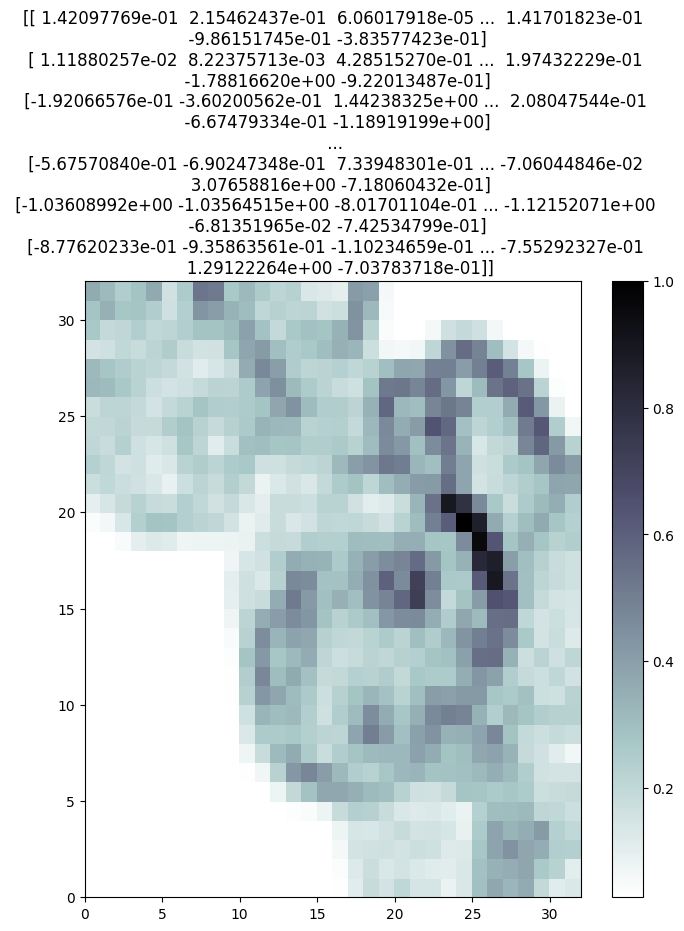

In [6]:
vis = Visualization(data, target, label_names, best_params)
vis.plot_som(som, data)

## Distance Map - Target
In this scenario, we had the possibility to assign the target variable at each neuron. So per each observation in the dataset the corresponding 'winner' neuron (the one with the smallest distance) will be assigned the target value.

In this scenario the size of each marker (square, circle, triangle) is proportional to the number of observations assigned to that neuron. 

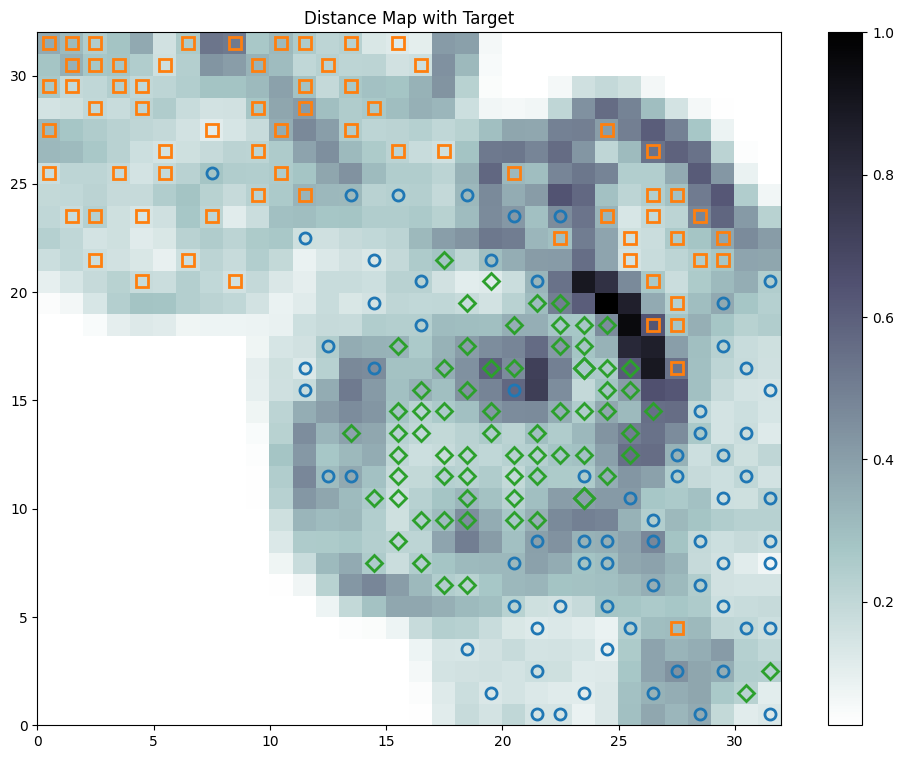

In [7]:
vis.plot_som_with_target(som, data, target)

## Distance Map - Clusters
Appling a simple clustering algorithm (in this case KMeans) on the neurons weights helps to understand the distribution of the data in the map, which in this case closely resembles the original data distribution.

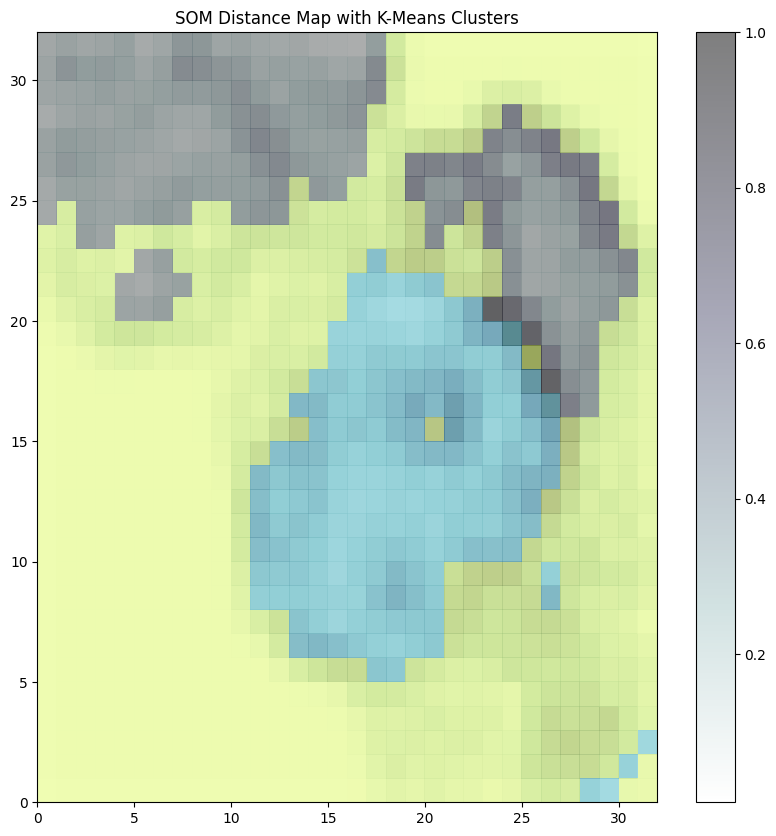

In [8]:
vis.plot_kmeans_on_som_distance_map(som, clusters=3)

## Distance Map - PCA weights
Since the initial studies of Kohonen it has been always a good practice to initialize the weights with the first two principal components of the data. This helps the algorithm to converge faster and to have a better representation of the data.

Hereby we can see the distance map of the weights of the neurons before/after the training.

#### Before training

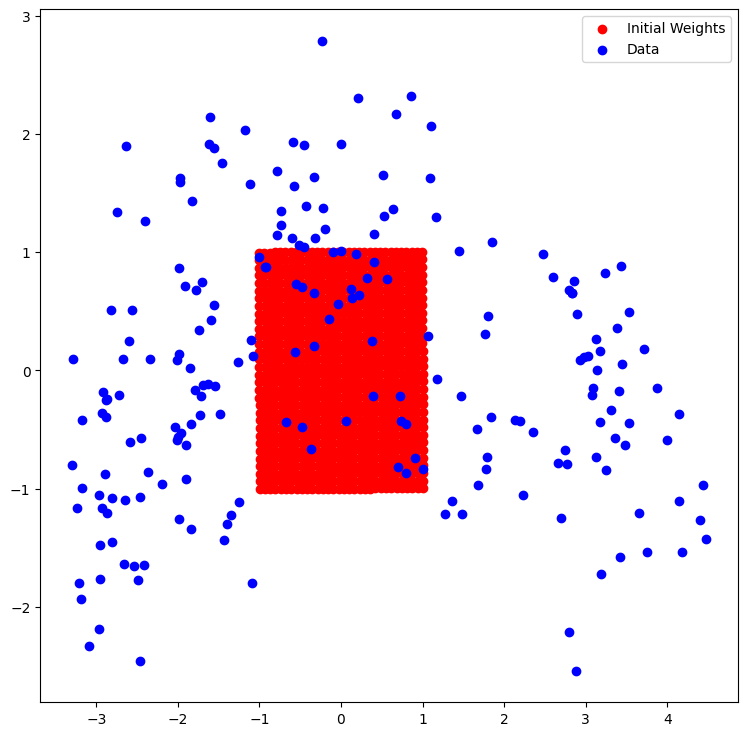

In [9]:
vis.plot_pca_initial_weights()

#### After training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.03194195063695642


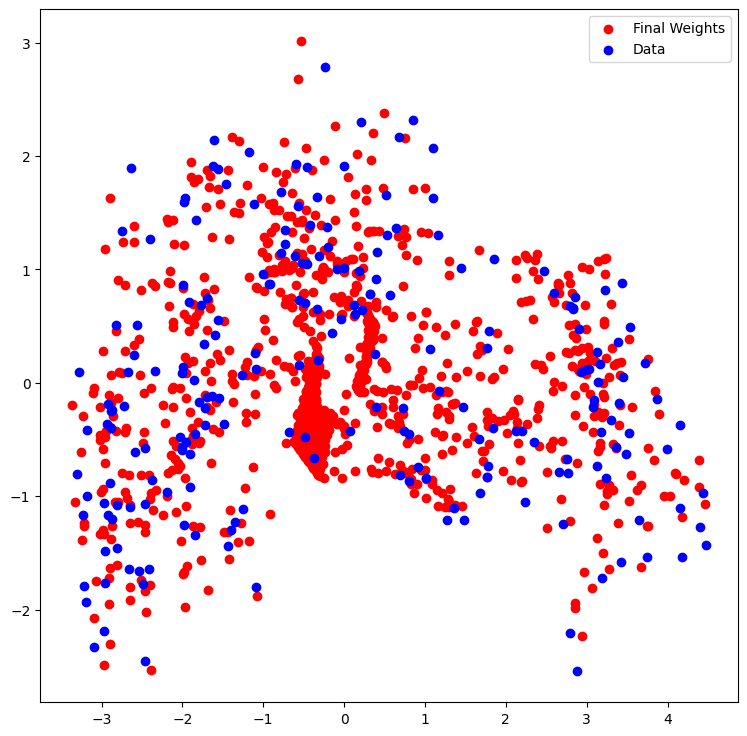

In [10]:
vis.plot_pca_final_weights()